# Figure 2: PANDA analysis of water

This notebook applies PANDA to a water sample. It generates figures for several intermediate steps, culminating in Figure 2. All of the core scientific logic is imported from `photoactivation.py`.

Updated 2015-11-16

## Overview

1. Import packages; load data and metadata.
2. Compute profiles.
3. Map each profile onto a future profile by convolving with a Gaussian.
4. Choose a representative value of $\sigma$ for each lag time $t$. Plot $\sigma(t)$.
5. Draw the final figure.


## Step 1: Import packages; load data and metadata.

All of the dependencies are given in the `environment.yml` file in this repository.

In [1]:
%matplotlib notebook

from itertools import cycle
from collections import OrderedDict

import yaml
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pims

import photoactivation as pa  # importing from photoactivation.py in the working directory

/Users/benjaminschuster/anaconda/envs/pa/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Use Bob's plot style preferences
mpl.style.use('https://tiny.cc/leheny-style/raw')

In [3]:
calibrations = yaml.load(open('calibrations.yml'))

In [4]:
filepath = "data/20140523 JCK20140519 10fold in H2O PLGA-PEG-Rhod Activation_20x 1.57sec 20 iterations 4 AU 2.lsm"
objective = '20X'
exposure_time = 1.570  # s
first_illuminated_frame = 5
mpp = calibrations[objective]

In [5]:
# A pims.pipeline is a function that only gets evaluated at the last moment.

@pims.pipeline
def grayscale(img):
    return np.sum(img, 0)
    
v = grayscale(pims.open(filepath))

<IPython.core.display.Javascript object>


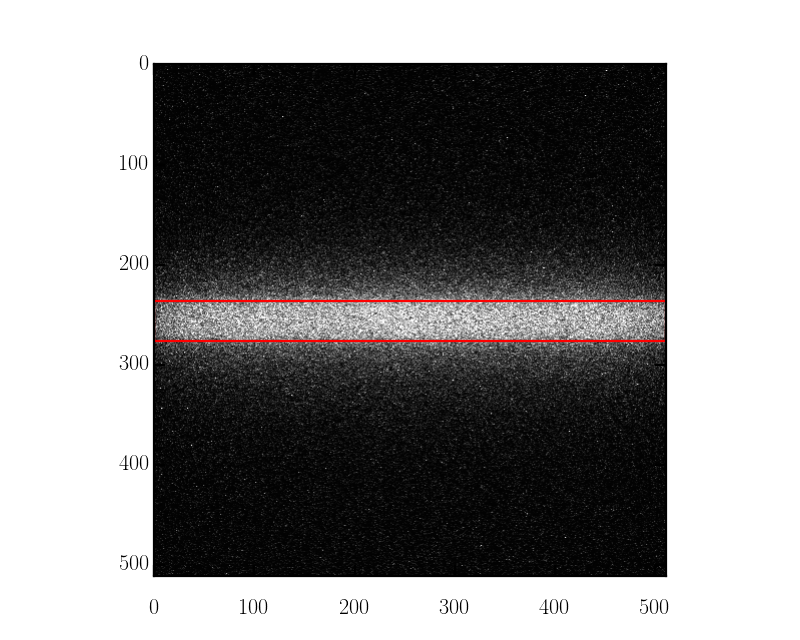

In [6]:
pa.outline_activation_region(v[first_illuminated_frame])

## Step 2: Compute profiles.

We define a function that sums along an axis, subtracts a constant background, and caches the result for fast repeated computations.

In [7]:
help(pa.make_profiler)

Help on function make_profiler in module photoactivation:

make_profiler(background, axis)
    Build a function that subtracts the background and sums along an axis
    
    Parameters
    ----------
    background : number
        intensity to subtract from the profile
    axis : int
        which axis to sum along
        
    Returns
    -------
    func :
        function with the signature (img_stack, i)



<IPython.core.display.Javascript object>


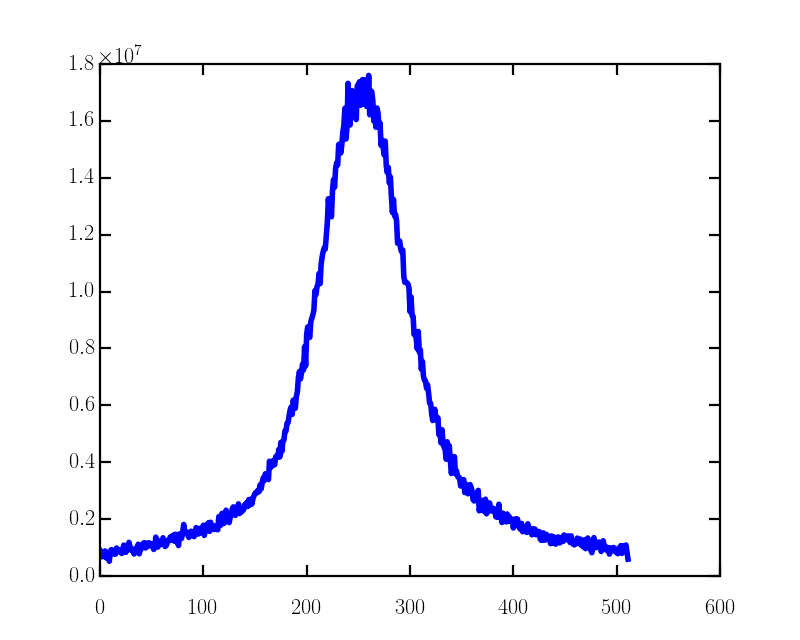

float64


In [8]:
profiler = pa.make_profiler(v[0].shape[1] * np.mean(v[0]), 1)

plt.figure()
plt.plot(profiler(v, 100))
print(profiler(v, 100).dtype)

## Step 3: Map each profile onto a future profile by convolving with a Gaussian.

Use a nonlinear-least-squared fit to determine the Gaussian kernel that best maps a given profile onto another profile.

To start, we'll map each profile onto the profile 40 frames in the future. We'll extract $\sigma$ from the best fit, and plot it.

In [9]:
help(pa.fit_profiles_recursively)

Help on function fit_profiles_recursively in module photoactivation:

fit_profiles_recursively(profiles, lag, *, recursive=True, bound=False)
    Parameters
    ----------
    profiles: list
        profiles evenly spaced in time
    lag : int
        profiles to skip
    recursive : bool, optional
        If True, use last fit as initial guess for current fit.
        True by default.
    bound : bool, optional
        If True, apply min/max bounds to the fit.
        False by default.
        
    Returns
    -------
    results : list
        list of lmfit Result objects



In [10]:
profiles = [profiler(v, i) for i in range(first_illuminated_frame, len(v))]
fit_results = pa.fit_profiles_recursively(profiles, 40)
sigmas = [mpp * fit_result.values['sigma'] for fit_result in fit_results]

<IPython.core.display.Javascript object>


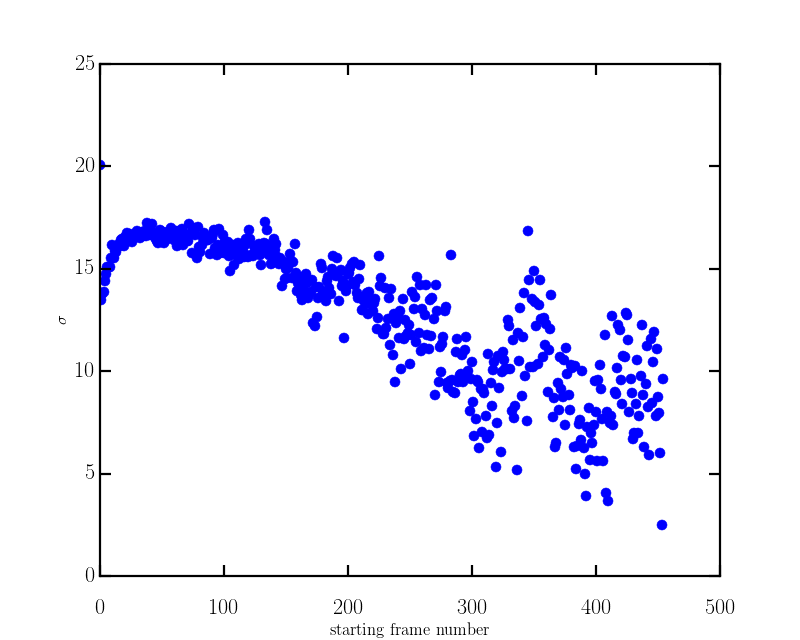

In [11]:
plt.figure()
plt.plot(sigmas, '.')
plt.ylabel('$\sigma$')
plt.xlabel('starting frame number')

We'll repeat this for several lag times.

In [12]:
lags = range(20, len(v), 20)  # e.g., 20, 40, ...
sigmas = OrderedDict()  # results buffer
for lag in lags:
    fit_results = pa.fit_profiles_recursively(profiles, lag)
    sigmas[lag] = [mpp * fit_result.values['sigma'] for fit_result in fit_results]

<IPython.core.display.Javascript object>


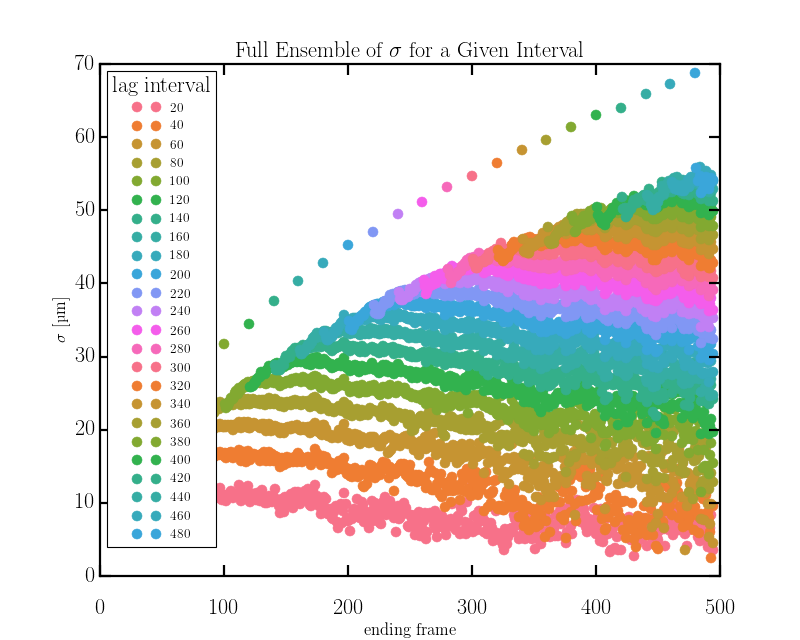

In [13]:
plt.figure()
rainbow_colors = cycle([(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.9386807511529497, 0.48901639250529133, 0.19623149776413562), (0.775731904186273, 0.5784925270759935, 0.19475566538551872), (0.6566480096570136, 0.6229564921397143, 0.1938976562578914), (0.5105309046900421, 0.6614299289084904, 0.1930849118538962), (0.19468252393000074, 0.6998280342882891, 0.3041476695746048), (0.20433460114757862, 0.6863857739476534, 0.5407103379425205), (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), (0.21662978923073606, 0.6676586160122123, 0.7318695594345369), (0.2266813382629933, 0.6508721810235698, 0.85618939194681), (0.5049017849530067, 0.5909119231215284, 0.9584657252128558), (0.7563369715809057, 0.5008642633638004, 0.9580503362615219), (0.9587050080494405, 0.36622595657917456, 0.9231469575614251), (0.9640248692994725, 0.41206779951067346, 0.7303540600728443)])

for lag, s in sigmas.items():
    plt.plot(lag + np.arange(len(s)), s, '.', label=lag, color=next(rainbow_colors))
    
plt.gca().set(xlabel='ending frame', ylabel=r'$\sigma$ [\textmu m]')
plt.gca().legend(loc='best', title='lag interval', fontsize=12)
plt.gca().set(title=r'Full Ensemble of $\sigma$ for a Given Interval')

There are evidently both random and systematic errors leading to some spread in the value of sigma at a given lag time as measured at different start and end times.

## Step 4: Choose a representative value of $\sigma$ for each lag time $t$. Plot $\sigma(t)$.

In [14]:
# Skip the first point. Take the mean of the remaining points.
representative_sigma = np.asarray([np.mean(s[1:]) for s in sigmas.values()])
lag_times = np.asarray(lags) * exposure_time

<IPython.core.display.Javascript object>


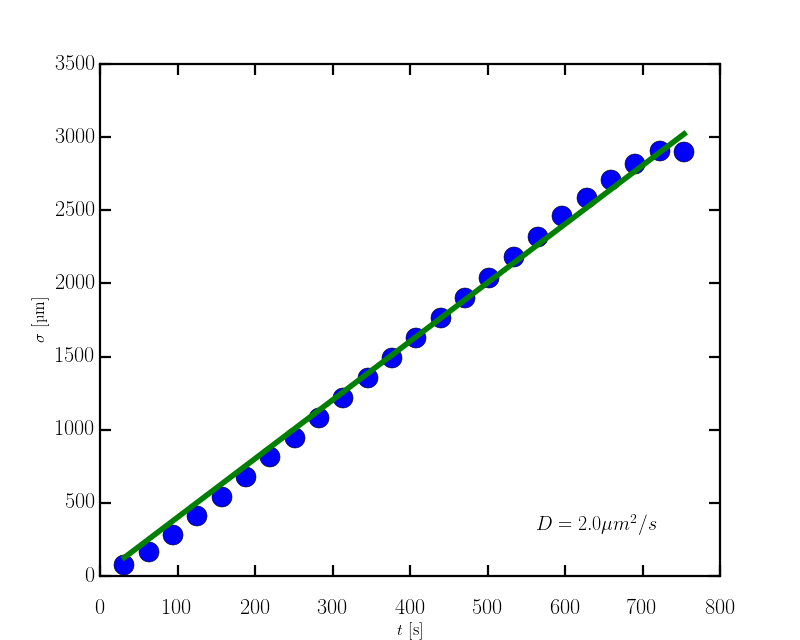

In [15]:
plt.figure()
plt.plot(lag_times, representative_sigma**2, 'o')
plt.ylabel(r'$\sigma$ [\textmu m]')
plt.xlabel(r'$t$ [s]')

In [16]:
slope, = pa.fit_line(lag_times, representative_sigma**2).params
D = slope/2

# Update the plot above, adding a best-fit line and a text annotation.
plt.plot(lag_times, slope * lag_times)
plt.text(0.8, 0.1, r'$D={:.3} \mu m^2/s$'.format(D), size=18,
         ha='center', va='center', transform=plt.gca().transAxes)

## Step 5: Draw the final figure

Dense matplotlib code lays out a grid of subfigures just the way we want them.

<IPython.core.display.Javascript object>


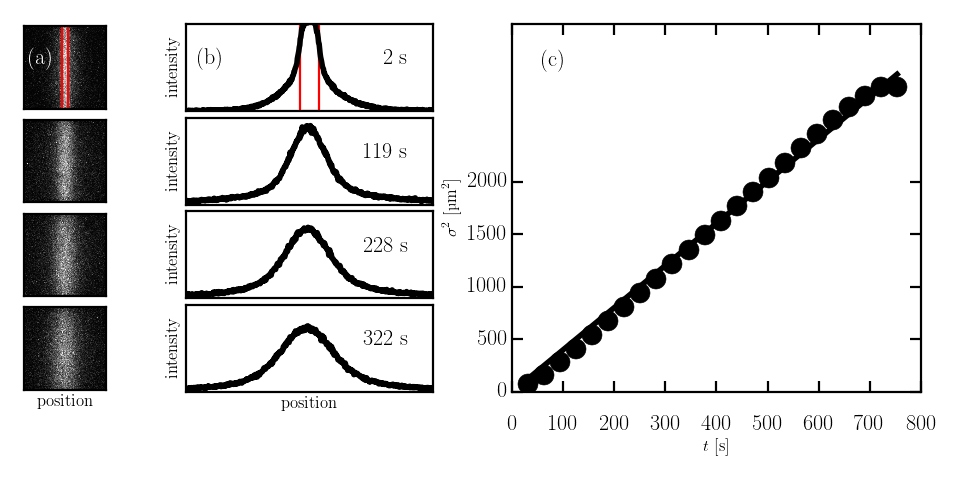

In [17]:
plt.figure(figsize=(12, 6))

# Construct a grid of subplots.
grid = mpl.gridspec.GridSpec(4, 4, width_ratios=[1, 3, 2, 2])
image_axes = list(map(plt.subplot, [grid[i, 0] for i in range(4)]))
profile_axes = list(map(plt.subplot, [grid[i, 1] for i in range(4)]))
plot_ax = plt.subplot(grid[:, 2:])

# Configure axes labels / ticks.
[ax.set(xticks=[], yticks=[]) for ax in image_axes]
[ax.set(xticks=[], yticks=[], ylabel='intensity') for ax in profile_axes]
profile_axes[-1].set(xlabel='position')
image_axes[-1].set(xlabel='position')
plot_ax.set(xlabel=r'$t$ [s]', ylabel=r'$\sigma^2$ [\textmu m$^2$]')

# Draw in the frames of video.
frame_nos = [6, 81, 150, 210]  # Ben chose [6, 81, 196, 387] but I'm missing 387 -- fix later!
for ax, frame_no in zip(image_axes, frame_nos):
    image = v[frame_no]
    # flip diagonally
    image = image.T
    ax.imshow(image)

# Draw in the profiles.
PROFILE_WINDOW_HEIGHT = 2e7
for ax, frame_no in zip(profile_axes, frame_nos):
    ax.plot(profiles[frame_no - first_illuminated_frame], 'k')
    ax.set(ylim=(0, PROFILE_WINDOW_HEIGHT))
    # Label the time
    t = int(round((frame_no - first_illuminated_frame) * exposure_time, 0))
    ax.text(0.9, 0.6, '{0} s'.format(t), ha='right', va='center', transform=ax.transAxes)
    
# Outline the activation region.
rectangle1 = mpl.patches.Rectangle((512//2 - 20, 0), 40, 511,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=image_axes[0].transData)
rectangle2 = mpl.patches.Rectangle((512//2 - 20, 0), 40, PROFILE_WINDOW_HEIGHT,
                                  facecolor='none', edgecolor='red', linewidth=2,
                                  transform=profile_axes[0].transData)
image_axes[0].add_patch(rectangle1)
profile_axes[0].add_patch(rectangle2)
    
# Draw in the sigma vs. t data.
plot_ax.plot(lag_times, representative_sigma**2, 'ko')
plot_ax.plot(lag_times, slope * lag_times, 'k-')
plot_ax.set(yticks=[0, 500, 1000, 1500, 2000])

# Label (a), (b), (c).
image_axes[0].text(0.2, 0.6, '(a)', ha='center', va='center', transform=image_axes[0].transAxes, color='white')
profile_axes[0].text(0.1, 0.6, '(b)', ha='center', va='center', transform=profile_axes[0].transAxes)
plot_ax.text(0.1, 0.9, '(c)', ha='center', va='center', transform=plot_ax.transAxes)

# Tweak subplot spacing.
# plot_ax.figure.set_size_inches(14.5, 7)
grid.tight_layout(plot_ax.figure, h_pad=0.3, w_pad=0.5)
